In [282]:
import matplotlib.pyplot as plt
import time
import torch
from torch import logsumexp
from torch.distributions.normal import Normal
import numpy as np
from utils import *
from plots import *

In [197]:
iterations = 5000
num_samples = 10
p_mu = 0.0
lr = 1e-3
log_Z = np.log(np.sqrt((2*np.pi)))

q_mu = torch.tensor([1.0], requires_grad=True) * 3.0
q_sigma = torch.tensor([1.0], requires_grad=True) * 1.0

In [269]:
def rws(num_samples, q_mu, q_sigma, lr):
    EUBO = []
    ELBO = []
    Mu = []
    Sigma = []
    Grad_mu = []
    Grad_sigma = []
    ESS = []
    time_start = time.time()
    for i in range(iterations):
        proposal = Normal(q_mu, q_sigma)
        xs = proposal.sample((num_samples,))
        log_gammas = (-1.0 / 2.0) * ((xs - p_mu) ** 2)
        log_q = proposal.log_prob(xs)
        log_weights = log_gammas - log_q
        weights = torch.exp(log_weights - logsumexp(log_weights, dim=0)).detach()
        ess = 1. / (weights ** 2).sum()
        eubo = torch.mul(weights, log_weights).sum()
        elbo = log_weights.mean()
        grads = torch.autograd.grad(eubo, [q_mu, q_sigma])
        q_mu = q_mu - lr * grads[0]
        q_sigma =  q_sigma - lr * grads[1]
        EUBO.append(eubo.item())
        ELBO.append(elbo.item())
        Mu.append(q_mu.item())
        Sigma.append(q_sigma.item())
        Grad_mu.append(grads[0].item())
        Grad_sigma.append(grads[1].item())
        ESS.append(ess.item())
        if i % 1000 == 0:
            time_end = time.time()
            print('iteration:%d, EUBO:%.3f, ELBO:%.3f, ESS:%.3f (%ds)' % (i, eubo, elbo, ess, (time_end - time_start)))
            time_start = time.time()
    return EUBO, ELBO, Mu, Sigma, Grad_mu, Grad_sigma, ESS

In [199]:
EUBO, ELBO, Mu, Sigma, Grad_mu, Grad_sigma, ESS = rws(num_samples, q_mu, q_sigma, lr)

iteration:0, EUBO:2.807, ELBO:-2.751, ESS:1.113 (0s)
iteration:1000, EUBO:1.694, ELBO:-2.291, ESS:4.267 (1s)
iteration:2000, EUBO:1.053, ELBO:-2.535, ESS:2.641 (3s)
iteration:3000, EUBO:1.326, ELBO:-0.628, ESS:6.715 (5s)
iteration:4000, EUBO:1.408, ELBO:-0.672, ESS:5.841 (6s)


/home/hao/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


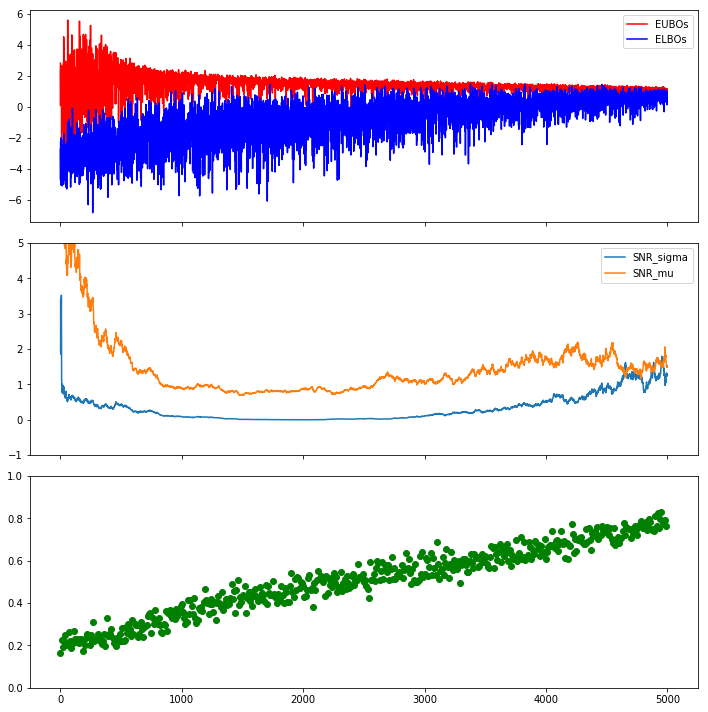

In [281]:
eg_mu, eg2_mu, var_mu, snr_mu = SNR(np.array(Grad_mu), iterations, beta1=0.99, beta2=0.999)    
eg_sigma, eg2_sigma, var_sigma, snr_sigma = SNR(np.array(Grad_sigma), iterations, beta1=0.99, beta2=0.999)    
plot_results(EUBO, ELBO, ESS, num_samples, snr_mu, snr_sigma)

/home/hao/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


(0, 4)

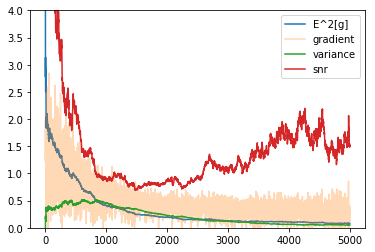

In [272]:
# snr_mu, snr_sigma = snrs(Grad_mu, Grad_sigma, iterations, beta1=0.9, beta2=0.99)
# plot_results(EUBO, ELBO, ESS, num_samples)
eg, eg2, var, snr = SNR(np.array(Grad_mu), iterations, 0.99, 0.999)
plt.plot(eg**2, label='E^2[g]')
plt.plot(Grad_mu, label='gradient', alpha=0.3)
plt.plot(var, label='variance')
plt.plot(snr, label='snr')
plt.legend()
plt.ylim([0,4])